## Learnings from Time Series, a Kaggle Course
Seasonality - time series with regular cadence of periodic change to the mean.  
Tend to follow calendar and clock cycles - over a day, a week, a month or a year are common.  
Two drivers of seasonality - cycles in nature and social conventions for behavior (ex. increased consumer goods spending Thanksgiving through Christmas)

## Features to Model Seasonality
Indicators - best for seasons with few observations. ex - weekly season of daily observations.  
Fourier - best for seasons with many observations. ex - annual season of daily observations.  

### Seasonal Plots
Used to discover seasonal patterns in time series data.  
Segments of the time series data are plotted over a common period, aka the season to observe.

### Indicators
Binary features representing differences in a time series for the season or commond period.  
Determined by treating a season as a categorical feature and applying one-hot encoding.

#### One Hot Encoding 
Technique to represent categorical variables as numeric values. Some models can't handle categorical variables.  Examples: item sizes, genders.  
Avoids problem of ordinality (ex: s, m l)  
Each value for the variable is assigned a column, usually a 1 or 1.0 is used to represent the observation has the value and 0 or 0.0 when not.  
Leads to sparse data - most observations have a value of 0 in most columns in one-hot encoded data.  
Can lead to increased dimenstionality, since there is a separate column for each category in the variable.  
May create complex, resource intensive (aka slow to train) models  
Alternatives are binary and ordinal encoding.  

#### Using with Linear Regression
Works best dropping one of the dummy features (columns) created by one-hot encoding.  
Adding seasonal indicators to the training data helps the model deistinguid means within a seasonal period.  
Model will learn a value for the dropped feature to use as baseline.  
Model adjusts by the value of whichever indicator is On.  Ex - only one can be On for any given day in a weekly time series one-hot encoded.  

### Fourier
Instead of creating feature for each date / observation period, tries to capture overall shape of seasonal curve with a few features.
Idea is to include periodic curves having the same frequences as the seasons we are trying to model in the training data.
These features are pairs of sine and cosine curves, one pair for each potential frequenqy in the seasons starting with the longest.
Ex - fourier pairs modeling annual seasonality would have frequencies like once per year, twice per year, three times per year.

#### Using with Linear Regression
Adding fourier pairs to the training data lets the algorithm figure out the weights that will fit the seasonal component in the target series.
Each pair produces a curve, each pair models a difference frequency, and the sum of the curves approximates the seasonal pattern.
Ex - three times per year has 6 features the 3 pairs of sine and cosine curves.
Usually results in adding far less features to large training data than seasonal indcicators - aka reduced computation and less risk of overfitting.

#### Periodogram with Fourier features
How do I determine how many Fourier pairs to include in the training data?  Using a periodogram.
Periodogram identifies the strength of the frequencies in a time series. 
The value on the y-axis is (a ** 2 + b **2) / 2, where a and b are the coefficients of the sine and cosine at that frequency.
Look for where their is drop-off, and ignore weekly or less since that is better modeled with seasonal indicators.

In [2]:
# An example of computing Fourier features
import numpy as np


def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)


# Compute Fourier features to the 4th order (8 new features) for a
# series y with daily observations and annual seasonality:
#
#fourier_features(y, freq=365.25, order=4)

## Tunnel Traffic Example

In [3]:
# setup
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

simplefilter("ignore")

In [5]:
# create plot defaults / style
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [6]:
# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [7]:
# get the data
data_dir = Path("./time_series_demo")
tunnel = pd.read_csv(data_dir / "tunnel.csv", parse_dates=["Day"])
tunnel = tunnel.set_index("Day").to_period("D")

<Axes: title={'center': 'Seasonal Plot (year/dayofyear)'}, xlabel='dayofyear', ylabel='NumVehicles'>

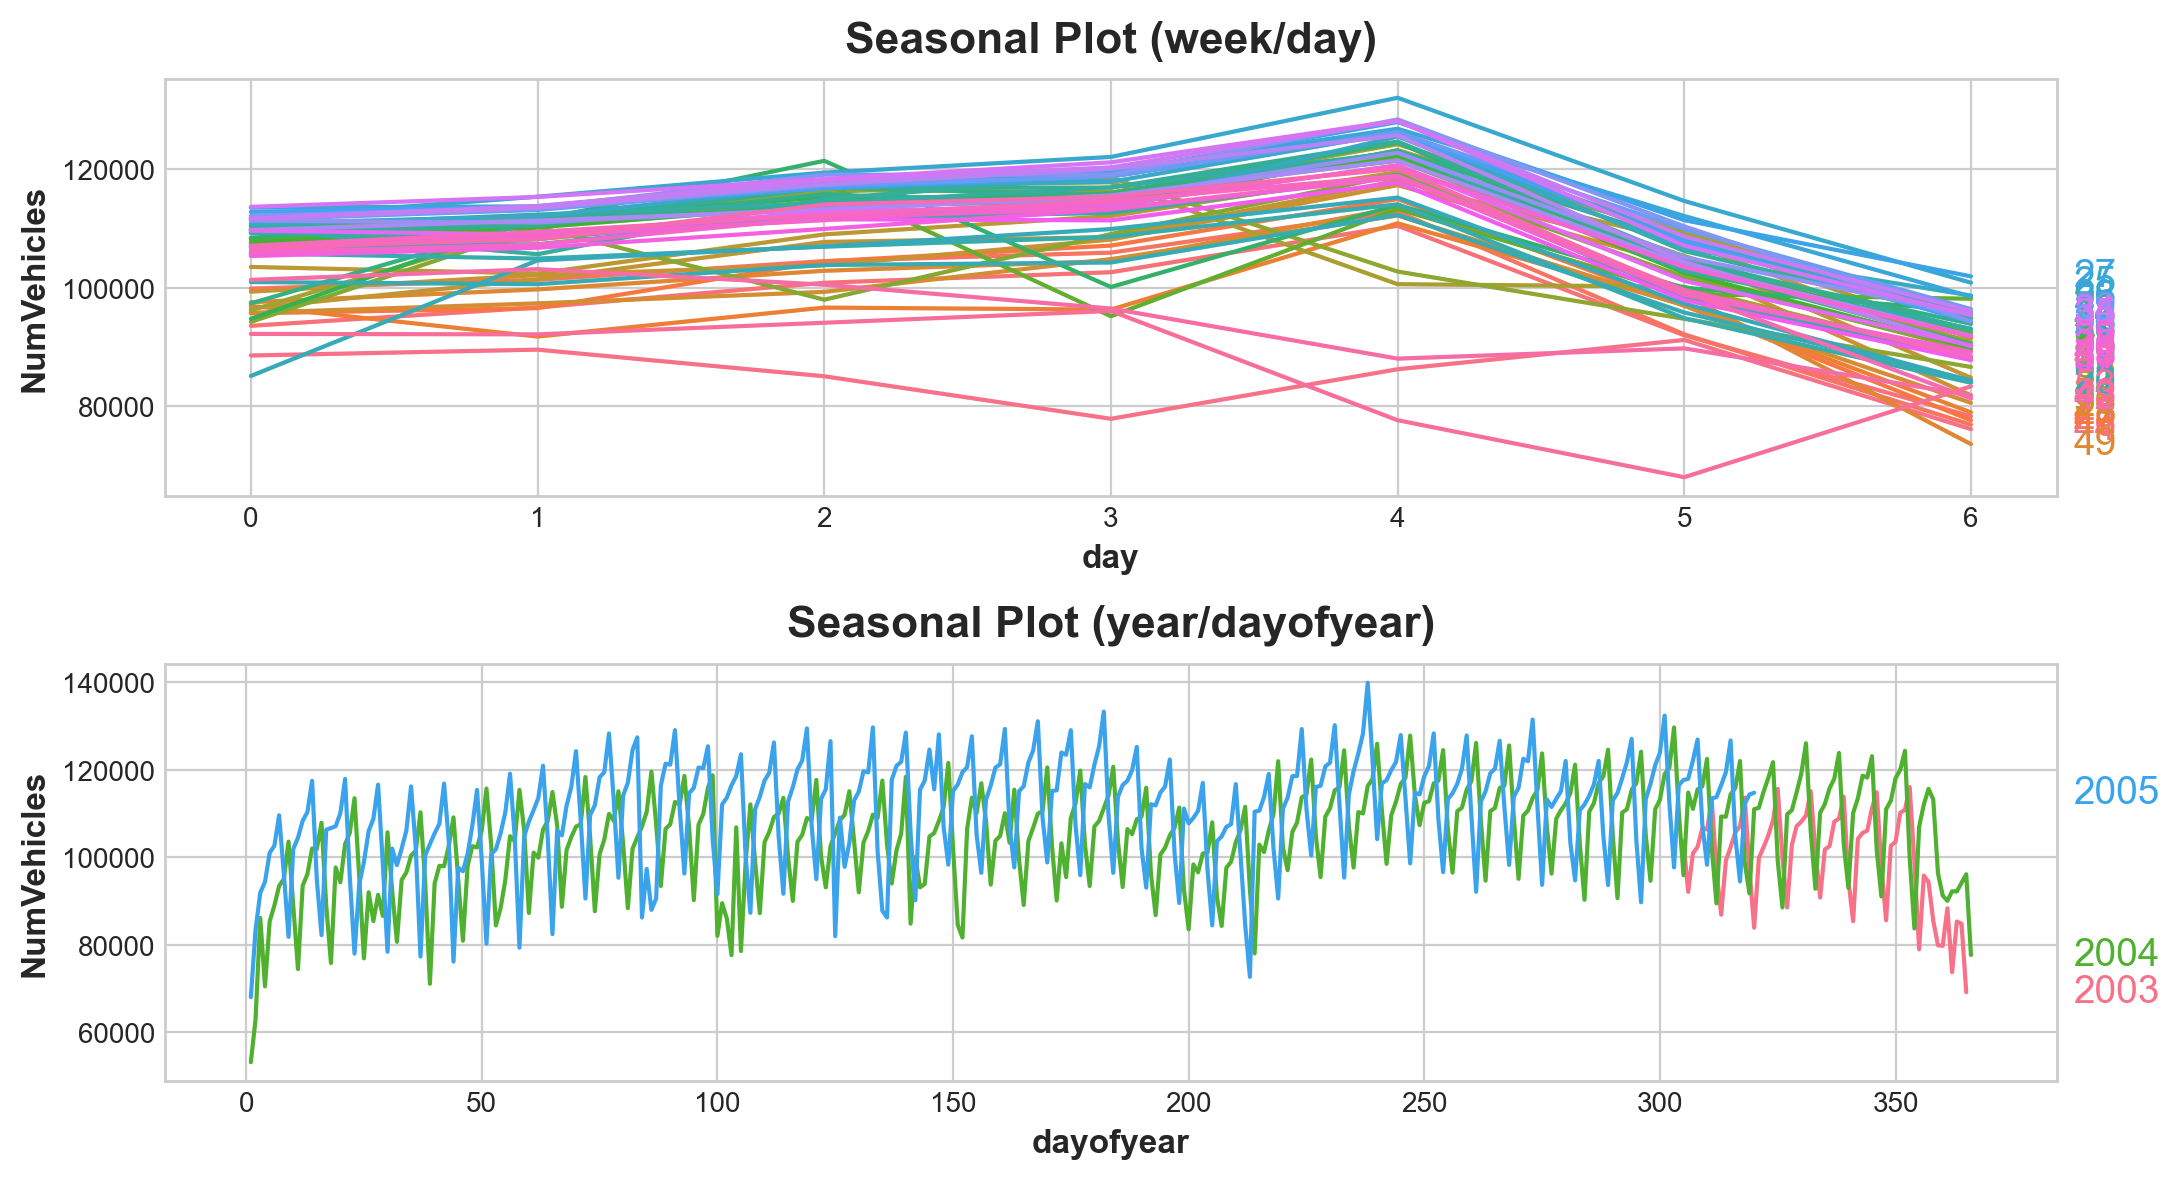

In [8]:
# make a seasonal plot
X = tunnel.copy()

# days within a week
X['day'] = X.index.dayofweek # the x-axis (frequency)
X['week'] = X.index.week # the seasonal period (period)

# days within a year
X['dayofyear'] = X.index.dayofyear
X['year'] = X.index.year

# plotting
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y='NumVehicles', period='week', freq='day', ax=ax0)
seasonal_plot(X, y='NumVehicles', period='year', freq='dayofyear', ax=ax1)

### Now to look at the periodogram

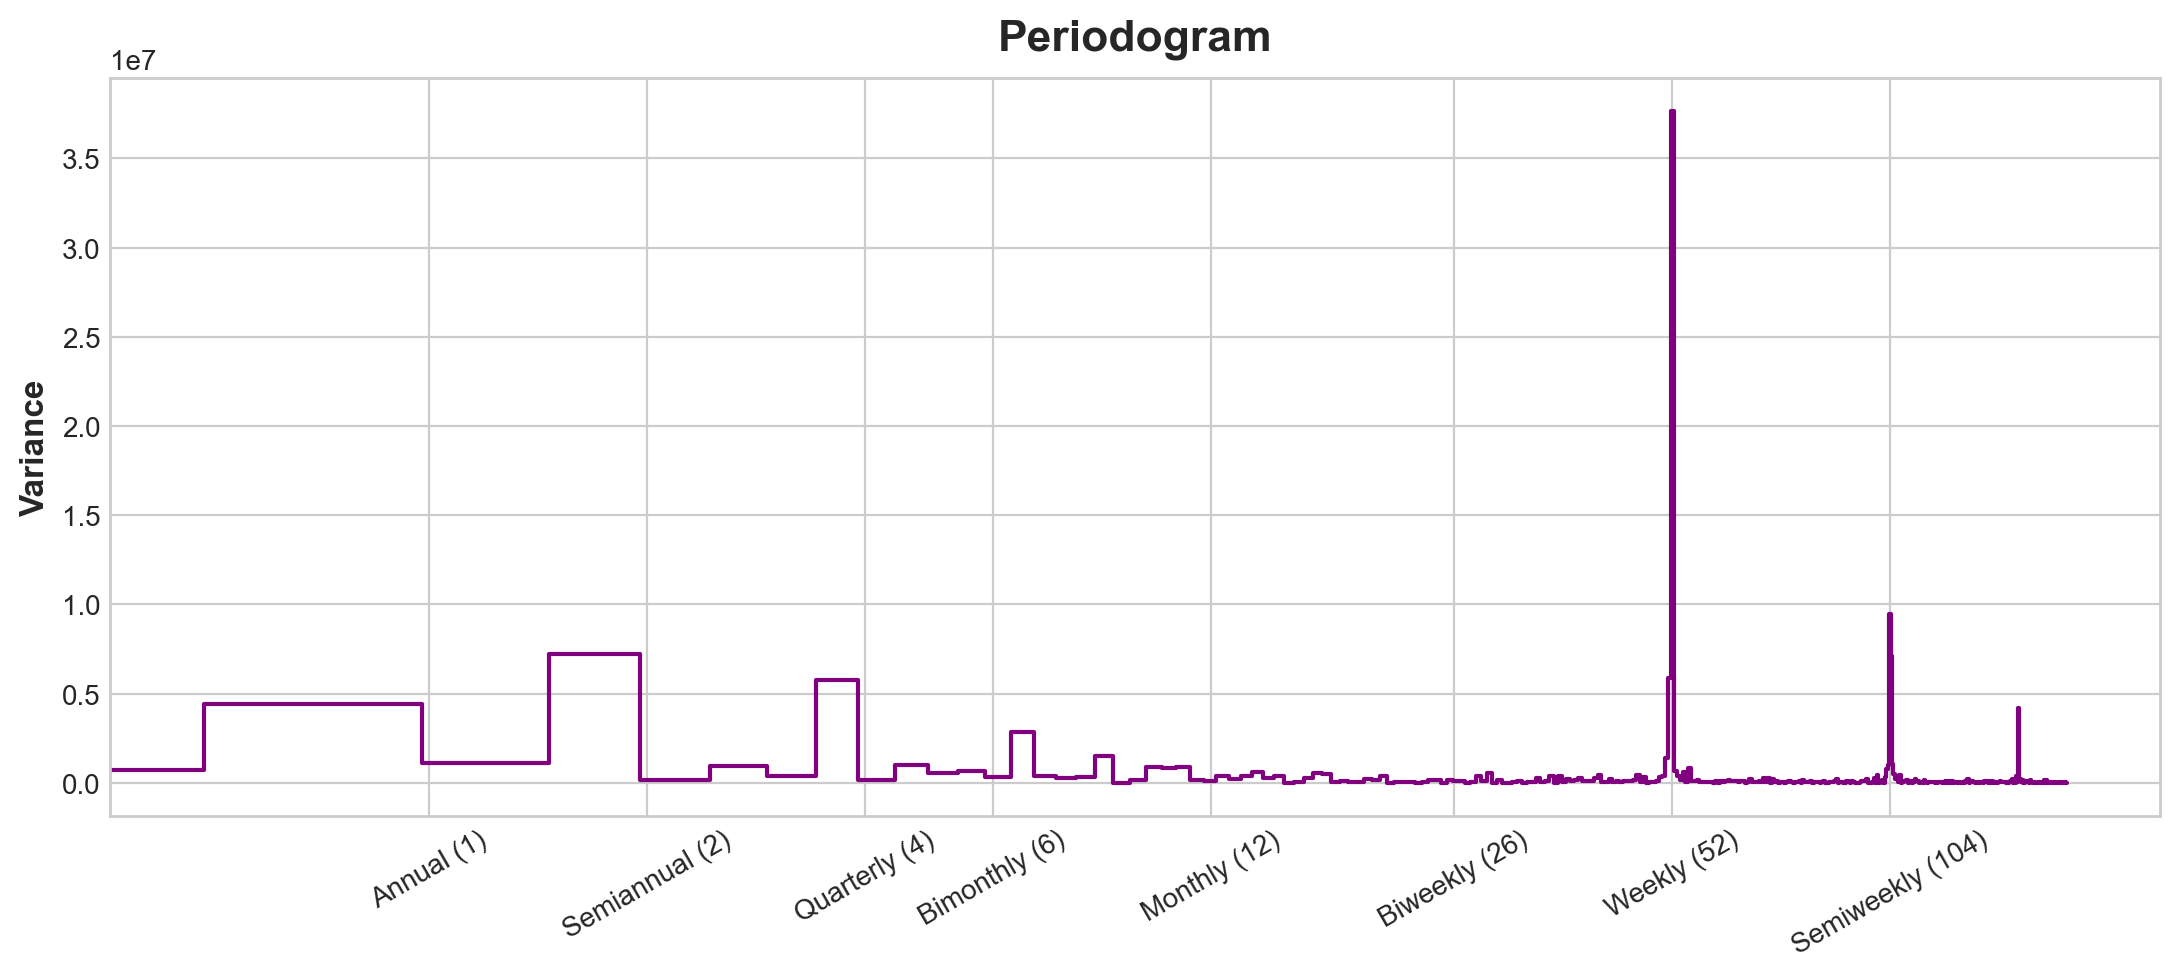

In [9]:
plot_periodogram(tunnel.NumVehicles);

### Findings
First seasonal plot showed strong weekly trends, periodogram agrees.
Second plot showed weaker annual season trends, periodgram agrees.
Drop off between bi-monthly and monthly variance.
So I should model weekly season with indicators and an annual season with Fourier features (between 6 and 12